# 相似度筛选

In [16]:
import os
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,QuantileTransformer
from sklearn.metrics.pairwise import cosine_similarity
import json

In [17]:
# 加载数据
df = pd.read_csv(r"C:\Users\Runker\Desktop\test\csv\point_sample.csv")

In [18]:
df.fillna(df.select_dtypes(include='number').mean(),inplace=True)

In [19]:
df.columns

Index(['point_id', 'longitude', 'latitude', 'Join_Count', 'TARGET_FID', 'TL',
       'YL', 'TS', 'TZ', 'label', 'LON', 'LAT', 'MZMC', 'DLDMN', 'DLMCN',
       'NEW_TL', 'NEW_YL', 'NEW_TS', 'NEW_TZ',
       'aligned_Analytical Hillshading', 'aligned_Aspect',
       'aligned_Channel Network Base Level',
       'aligned_Channel Network Distance', 'aligned_Closed Depressions',
       'aligned_Convergence Index', 'aligned_dem', 'aligned_ETP2022',
       'aligned_ETP2022_1', 'aligned_ETP2022_10', 'aligned_ETP2022_11',
       'aligned_ETP2022_12', 'aligned_ETP2022_2', 'aligned_ETP2022_3',
       'aligned_ETP2022_4', 'aligned_ETP2022_5', 'aligned_ETP2022_6',
       'aligned_ETP2022_7', 'aligned_ETP2022_8', 'aligned_ETP2022_9',
       'aligned_ETP2022_mean', 'aligned_evi', 'aligned_LS-Factor',
       'aligned_lswi', 'aligned_mndwi', 'aligned_ndmi', 'aligned_ndvi',
       'aligned_ndwi', 'aligned_NIGHT2022', 'aligned_pca_1', 'aligned_pca_2',
       'aligned_Plan Curvature', 'aligned_PRE2022', 'a

In [20]:
# 区分点位
no_calc_df = df[df['label']=='inner']
train_df = df[df['label']=='fish_net']

In [21]:
feature_columns = ['aligned_Analytical Hillshading', 'aligned_Aspect',
       'aligned_Channel Network Base Level',
       'aligned_Channel Network Distance', 'aligned_Closed Depressions',
       'aligned_Convergence Index', 'aligned_dem', 
       'aligned_ETP2022_mean', 'aligned_evi', 'aligned_LS-Factor',
       'aligned_lswi', 'aligned_mndwi', 'aligned_ndmi', 'aligned_ndvi',
       'aligned_ndwi', 'aligned_NIGHT2022', 'aligned_pca_1', 'aligned_pca_2',
       'aligned_Plan Curvature', 'aligned_PRE2022_mean',
       'aligned_Profile Curvature', 'aligned_Relative Slope Position',
       'aligned_savi', 'aligned_Slope', 'aligned_TMP2022_mean',
       'aligned_Topographic Wetness Index', 'aligned_Total Catchment Area',
       'aligned_Valley Depth', 'aligned_vari', 'clipped_dem','MRRTF', 'MRVBF', 'slope_postion_101']

In [22]:
# 标签值
label_column = 'NEW_TS'

In [23]:
# 获取标签的唯一值
label_values = train_df[label_column].unique()

# 初始化用于存储代表性样本的列表
representative_samples = []

# 设置相似度阈值
threshold = 0.80  # 根据需要调整

# 遍历每个标签值
for label_value in label_values:
    # 提取当前标签值的样本
    label_df = train_df[train_df[label_column] == label_value]
    
    # 检查样本数量
    num_samples = len(label_df)
    if num_samples == 1:
        # 如果样本数量为1，直接添加该样本
        representative_samples.append(label_df.iloc[0].values)
    else:
        # 对特征进行标准化
        scaler = StandardScaler()
        # scaler = MinMaxScaler()
        # scaler = MaxAbsScaler()
        # scaler = QuantileTransformer()
        features_scaled = scaler.fit_transform(label_df[feature_columns])

        # 计算样本间的余弦相似度
        similarity_matrix = cosine_similarity(features_scaled)

        # 初始化用于存储选定样本索引的集合
        selected_samples = set()

        # 遍历相似度矩阵，选择相似度高于阈值的样本
        for i in range(len(similarity_matrix)):
            for j in range(i + 1, len(similarity_matrix)):
                if similarity_matrix[i, j] > threshold:
                    selected_samples.add(i)
                    selected_samples.add(j)

        if len(selected_samples) == 0:
            print(label_value, f"共有样本{label_df.shape[0]}个","没有找到相似的样本")
            # 如果selected_samples为空，添加相似度最高的15%的样本
            num_to_add = math.ceil(0.75 * num_samples)
            if num_to_add > 0:
                top_indices = similarity_matrix.sum(axis=0).argsort()[::-1][:num_to_add]
                selected_samples.update(top_indices)

        # 从原始样本中提取选定的样本
        selected_samples_indices = label_df.index[list(selected_samples)]
        representative_samples.extend(df.loc[selected_samples_indices].values)

# 转换为 DataFrame 并显示部分结果
representative_samples_df = pd.DataFrame(representative_samples, columns=df.columns)


泥质酸性粗骨土 共有样本8个 没有找到相似的样本
红泥田 共有样本9个 没有找到相似的样本
青白粉泥田 共有样本13个 没有找到相似的样本
漂砂泥田 共有样本10个 没有找到相似的样本
浅黄泥田 共有样本13个 没有找到相似的样本
青鳝泥田 共有样本3个 没有找到相似的样本
黄白粉泥田 共有样本10个 没有找到相似的样本
黄潮泥田 共有样本8个 没有找到相似的样本
青紫泥田 共有样本5个 没有找到相似的样本
冷水泥田 共有样本12个 没有找到相似的样本
青灰泥田 共有样本6个 没有找到相似的样本
灰泥质石灰性粗骨土 共有样本8个 没有找到相似的样本
砂质灰潮土 共有样本5个 没有找到相似的样本
浅红泥田 共有样本18个 没有找到相似的样本
砂泥田 共有样本9个 没有找到相似的样本
黏质中性紫色土 共有样本3个 没有找到相似的样本
浅暗泥田 共有样本11个 没有找到相似的样本


In [24]:
len(representative_samples_df)

29545

In [25]:
# 检查类别是否丢失
old_type = train_df[label_column].value_counts()
new_type = representative_samples_df[label_column].value_counts()
old_type.shape,new_type.shape

((47,), (47,))

In [26]:
# 再合并
result_df = pd.concat([representative_samples_df,no_calc_df],ignore_index=True)
# result_df = result_df.drop(columns=['label'])

In [27]:
result_df

,point_id,longitude,latitude,Join_Count,TARGET_FID,TL,YL,TS,TZ,label,...,aligned_Topographic Wetness Index,aligned_Total Catchment Area,aligned_Valley Depth,aligned_vari,clipped_dem,lat,lon,MRRTF,MRVBF,slope_postion_101
0,0,544939.9675,2963566.466,1,1,黄壤,黄壤,硅质黄壤,簿层硅质黄壤,fish_net,...,3.736111,299.832001,104.505737,0.395760,755.799988,2963565,544940,0.000175,0.000267,2
1,1,545139.9675,2963566.466,1,2,黄壤,黄壤,硅质黄壤,簿层硅质黄壤,fish_net,...,3.021536,84.143555,4.558105,0.471354,895.400024,2963565,545140,0.098559,0.027821,5
2,2,545139.9675,2963766.466,1,5,黄壤,黄壤,硅质黄壤,簿层硅质黄壤,fish_net,...,3.606110,263.281952,39.638428,0.346049,827.200012,2963765,545140,0.000512,0.000783,4
3,4,544539.9675,2963966.466,1,8,紫色土,酸性紫色土,酸性紫色土,薄层酸性紫色土,fish_net,...,4.521689,358.763886,100.718628,0.549107,670.799988,2963965,544540,0.006933,0.026543,2
4,6,545939.9675,2963966.466,1,15,黄壤,黄壤,硅铝质黄壤,簿层硅铝质黄壤,fish_net,...,4.010557,212.432388,5.399170,0.526882,1078.699951,2963965,545940,0.092846,0.113874,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32527,34886,492546.5876,3002418.081,0,0,黄壤,黄壤,硅铁质黄壤,厚层硅铁质黄壤,inner,...,4.298576,106.711266,0.267822,0.327062,958.099976,3002420,492545,2.295981,0.576791,6
32528,34887,495296.1560,3001912.599,0,0,黄壤,黄壤,硅铁质黄壤,厚层硅铁质黄壤,inner,...,5.703288,539.738586,8.388794,0.285978,1003.900024,3001915,495295,0.237154,0.743937,5
32529,34888,528302.1427,2993075.492,0,0,黄壤,黄壤,硅铁质黄壤,中层硅铁质黄壤,inner,...,5.063060,276.628723,31.121216,0.304948,705.400024,2993075,528300,0.475914,0.351047,4
32530,34889,528754.6367,2993315.946,0,0,黄壤,黄壤,硅铁质黄壤,中层硅铁质黄壤,inner,...,4.504801,185.424927,15.168701,0.048685,731.099976,2993315,528755,0.495911,0.422755,4


In [28]:
result_df['NEW_TZ'].value_counts().to_dict()

{'腐中层壤质黄色石灰土': 6585,
 '腐薄层壤质黄色石灰土': 4811,
 '腐厚层壤质黄色石灰土': 2353,
 '腐中层硅质黄壤': 2103,
 '腐中层灰泥质黄壤': 2053,
 '腐中层泥质黄壤': 1548,
 '腐厚层灰泥质黄壤': 1284,
 '中层壤质黄色石灰土': 1137,
 '腐薄层硅质黄壤': 1116,
 '腐薄层灰泥质黄壤': 827,
 '腐中层黏质黄色石灰土': 819,
 '腐薄层泥质黄壤': 810,
 '薄层壤质黄色石灰土': 640,
 '腐厚层泥质黄壤': 534,
 '腐厚层硅质黄壤': 524,
 '厚层壤质黄色石灰土': 459,
 '中层黏质黄色石灰土': 451,
 '中层灰泥质黄壤': 420,
 '石灰泥田': 264,
 '腐薄层黏质黄色石灰土': 235,
 '厚层灰泥质黄壤': 233,
 '中层硅质黄壤': 217,
 '浅石灰泥田': 215,
 '腐厚层黏质黄色石灰土': 185,
 '腐中层暗泥质黄壤': 182,
 '中层泥质黄壤': 165,
 '薄层泥质黄壤': 158,
 '薄层灰泥质黄壤': 154,
 '腐薄层暗泥质黄壤': 143,
 '潮泥田': 116,
 '黄浅白粉泥田': 96,
 '腐厚层泥质黄棕壤': 95,
 '腐中层红泥质黄壤': 91,
 '腐薄层泥质黄棕壤': 88,
 '腐薄层红泥质黄壤': 74,
 '中层红泥质黄壤': 73,
 '潮砂泥田': 67,
 '薄层硅质黄壤': 67,
 '腐中层泥质黄棕壤': 67,
 '腐中层砂泥质黄壤': 59,
 '厚层黏质黄色石灰土': 59,
 '腐厚层红泥质黄壤': 49,
 '厚层泥质黄壤': 45,
 '黄白粉泥田': 44,
 '黄浅鳝泥田': 39,
 '厚层红泥质黄壤': 39,
 '腐中层壤质中性紫色土': 37,
 '青灰泥田': 35,
 '黄黄泥田': 35,
 '腐厚层暗泥质黄壤': 34,
 '薄层红泥质黄壤': 30,
 '厚层硅质黄壤': 30,
 '薄层壤质中性紫色土': 29,
 '浅鳝泥田': 29,
 '紫泥田': 23,
 '中层砂泥质黄壤': 22,
 '薄层黏质黄色石灰土': 22,
 '浅黄泥田': 21,
 '腐薄层壤质中性紫色土': 20,
 '黄浅灰

In [14]:
out_path = r"F:\cache_data\frequency_filter\dy\scaler_csv"
result_df.to_csv(os.path.join(out_path,'dy_stander_filter_all_type_20240417.csv'),index=False)

In [20]:
df_filter = pd.read_csv(r"F:\cache_data\frequency_filter\dy\scaler_csv\dy_stander_filter_all_type_20240417.csv")

# 分类系统更新

Original training samples: 31910
Representative samples after filtering: 560
Final result samples (including inner points): 3548
Original categories: 112, Categories after filtering: 112
Original data cross-validation score: 0.1726 (+/- 0.0608)
Filtered data cross-validation score: 0.2036 (+/- 0.0778)


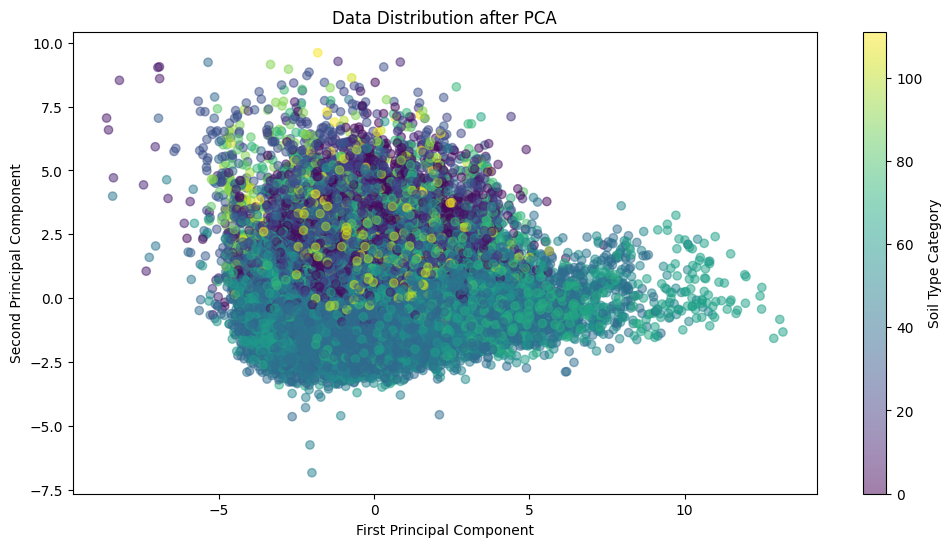

In [15]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from collections import Counter
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load data
df = pd.read_csv(r"C:\Users\Runker\Desktop\test\csv\point_sample.csv")
df.fillna(df.select_dtypes(include='number').mean(), inplace=True)

# Separate points
no_calc_df = df[df['label'] == 'inner']
train_df = df[df['label'] == 'fish_net']

feature_columns = [
                   'aligned_Channel Network Base Level',
                   'aligned_Channel Network Distance', 
                'aligned_dem', 
                   'aligned_ETP2022_mean', 'aligned_evi', 'aligned_LS-Factor',
                    'aligned_ndvi',
                   'aligned_ndwi', 'aligned_NIGHT2022', 'aligned_pca_1', 
                 'aligned_PRE2022_mean',
                    'aligned_Relative Slope Position',
                   'aligned_savi', 'aligned_Slope', 'aligned_TMP2022_mean',
                   'aligned_Topographic Wetness Index', 'aligned_Total Catchment Area',
                   'aligned_Valley Depth', 'aligned_vari', 'clipped_dem','MRRTF', 'MRVBF', 'slope_postion_101']
label_column = 'NEW_TZ'

# Feature selection using mutual information
mi_scores = mutual_info_classif(train_df[feature_columns], train_df[label_column])
mi_scores = pd.Series(mi_scores, index=feature_columns)
selected_features = mi_scores.nlargest(15).index.tolist()

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_df[selected_features])

# PCA
pca = PCA(n_components=0.80)
X_pca = pca.fit_transform(X_scaled)

# Adaptive sampling strategy
class_counts = Counter(train_df[label_column])
sampling_strategy = {cls: max(50, count) for cls, count in class_counts.items()}

# Apply random over-sampling
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_pca, train_df[label_column])

# Function to select representative samples
def select_representative_samples(X, y, n_clusters=5):
    if len(X) <= n_clusters:
        return list(zip(X, y))
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X)
    
    representatives = []
    for cluster in range(n_clusters):
        cluster_points = X[clusters == cluster]
        cluster_labels = y[clusters == cluster]
        if len(cluster_points) > 0:
            center = cluster_points.mean(axis=0)
            distances = np.sum((cluster_points - center) ** 2, axis=1)
            representative_idx = np.argmin(distances)
            representatives.append((cluster_points[representative_idx], cluster_labels.iloc[representative_idx]))
        else:
            # If the cluster is empty, select a random point from X
            random_idx = np.random.randint(len(X))
            representatives.append((X[random_idx], y.iloc[random_idx]))
    
    return representatives

# Select representative samples for each class
representative_samples = []
for label_value in np.unique(y_resampled):
    X_label = X_resampled[y_resampled == label_value]
    y_label = pd.Series(y_resampled[y_resampled == label_value])
    n_clusters = min(5, len(X_label))
    representatives = select_representative_samples(X_label, y_label, n_clusters=n_clusters)
    representative_samples.extend(representatives)

# Convert to DataFrame
representative_samples_df = pd.DataFrame([sample[0] for sample in representative_samples], 
                                         columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
representative_samples_df[label_column] = [sample[1] for sample in representative_samples]

# Inverse transform PCA and scaling
X_original = scaler.inverse_transform(pca.inverse_transform(representative_samples_df.drop(label_column, axis=1)))
representative_samples_df[selected_features] = X_original

# Merge with no_calc_df
result_df = pd.concat([representative_samples_df, no_calc_df], ignore_index=True)

# Save results
# out_path = r"F:\cache_data\frequency_filter\dy\scaler_csv"
# result_df.to_csv(os.path.join(out_path, 'dy_optimized_filter_all_type_20240417.csv'), index=False)

# Output statistics
print(f"Original training samples: {len(train_df)}")
print(f"Representative samples after filtering: {len(representative_samples_df)}")
print(f"Final result samples (including inner points): {len(result_df)}")

# Check if any categories are lost
old_type = train_df[label_column].value_counts()
new_type = representative_samples_df[label_column].value_counts()
print(f"Original categories: {len(old_type)}, Categories after filtering: {len(new_type)}")

# Evaluate the quality of the representative samples
rf_original = RandomForestClassifier(random_state=42)
original_scores = cross_val_score(rf_original, train_df[selected_features], train_df[label_column], cv=5)

rf_filtered = RandomForestClassifier(random_state=42)
filtered_scores = cross_val_score(rf_filtered, representative_samples_df[selected_features], 
                                  representative_samples_df[label_column], cv=5)

print(f"Original data cross-validation score: {np.mean(original_scores):.4f} (+/- {np.std(original_scores) * 2:.4f})")
print(f"Filtered data cross-validation score: {np.mean(filtered_scores):.4f} (+/- {np.std(filtered_scores) * 2:.4f})")

# Visualization (if needed)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_df[label_column].astype('category').cat.codes, alpha=0.5)
plt.title('Data Distribution after PCA')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='Soil Type Category')
plt.show()

In [22]:
result_df['TZ'].value_counts()

TZ
中层黄色石灰土     591
簿层黄色石灰土     419
大泥          397
大土泥         341
黄砂泥         298
           ... 
火石砂土          2
寡黄泥           2
龙凤大眼泥         2
浇血泥           1
簿层硅铁质黄棕壤      1
Name: count, Length: 75, dtype: int64

In [38]:
# 字典
json_file_path = 'D:\worker_code\Terrain_Test\data\soil_dict\soil_dict.json'
# 读取字典
with open(json_file_path, 'r', encoding='utf-8') as json_file:
    loaded_dict = json.load(json_file)

In [39]:
# 表
df_path = r"F:\cache_data\frequency_filter\dy\scaler_csv\dy_stander_filter_all_type.csv"
df = pd.read_csv(df_path)

In [40]:
# 获取当前的土种信息
tz_list = list(df['TZ'].unique())

In [41]:
# 检查tz_list中的土种是否在对照字典中
check_list = [x in loaded_dict for x in tz_list]
in_dict = check_list.count(True)
not_in_dict = check_list.count(False)
in_dict,not_in_dict

(18, 67)

In [42]:
# 获取现有数据土种字典
tz_dict = df.groupby('TZ').apply(lambda x: x[['TL', 'YL', 'TS']].drop_duplicates().to_dict(orient='records')).to_dict()


In [46]:

dfs = []

# 遍历字典，将每个分组的数据转换为 DataFrame 并添加到列表中
for tz, records in tz_dict.items():
    # 将 records 转换为 DataFrame
    df_temp = pd.DataFrame(records)
    # 添加 'TZ' 列，并设置值为当前的 tz
    df_temp['TZ'] = tz
    # 将 df_temp 添加到列表中
    dfs.append(df_temp)

# 使用 pd.concat 将所有的 DataFrame 连接起来
df_new = pd.concat(dfs, ignore_index=True)

# 重置索引
df_new.reset_index(drop=True, inplace=True)


In [48]:
df_new.to_excel(r"C:\Users\Runker\Desktop\test2.xlsx",index=False)

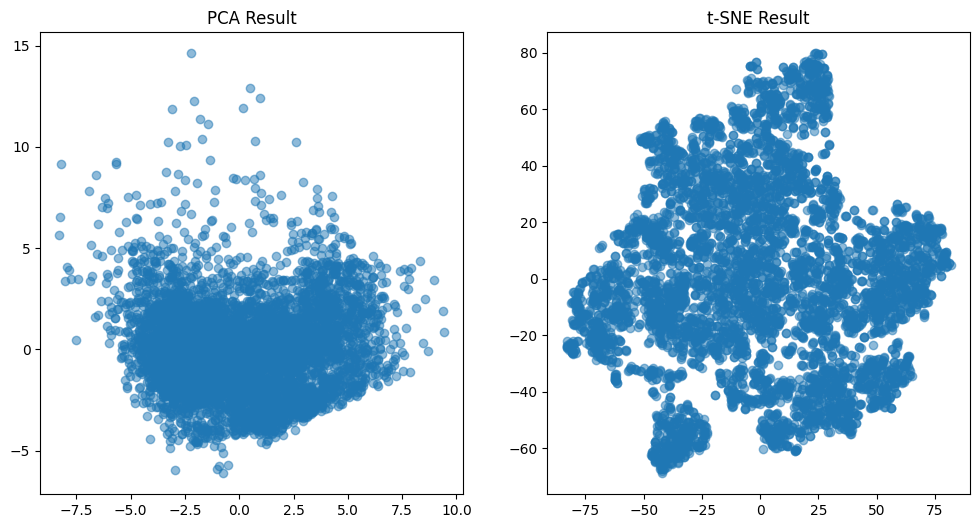

(array([[ 0.44389876,  0.41542511,  4.59090058, ...,  0.14469835,
         -0.10485392,  0.0347236 ],
        [-4.47852685, -1.22168342,  0.20931039, ...,  0.10027362,
         -0.01773527,  0.03416027],
        [-7.40781406,  3.47183565, -1.40278391, ...,  0.20095242,
          0.1945249 , -0.17827764],
        ...,
        [ 4.44238339, -0.7846033 ,  0.69290424, ..., -0.21538589,
         -0.0271332 , -0.21784226],
        [ 3.42972249,  0.90764521, -1.06342946, ..., -0.21877032,
          0.15133231,  0.21436183],
        [ 0.96177003,  1.89180207, -2.96170201, ...,  0.05287275,
          0.04755   , -0.10726042]]),
 array([[  8.678411 ,  34.75839  ],
        [-41.59352  , -10.6595125],
        [-51.21629  ,  48.705505 ],
        ...,
        [ 41.436348 ,   2.9045024],
        [ 51.711872 ,   8.781491 ],
        [ 39.399296 , -13.177542 ]], dtype=float32))

In [29]:
import warnings
features = result_df.drop(columns=['TZ'])
# 禁用 FutureWarning 类型的警告
warnings.simplefilter(action='ignore', category=FutureWarning)

# 执行代码

# 恢复警告设置
# warnings.resetwarnings()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 对特征进行标准化
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 应用 PCA
pca = PCA(n_components=30)
pca_result = pca.fit_transform(features_scaled)

# 应用 t-SNE，明确设置 init 为 'pca'
tsne = TSNE(n_components=2, random_state=0, init='pca', learning_rate='auto')  # 显式设置 init 和 learning_rate
tsne_result = tsne.fit_transform(features_scaled)

# 可视化 PCA 和 t-SNE 的结果
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA Result')

plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
plt.title('t-SNE Result')

plt.show()

# 返回 PCA 和 t-SNE 结果以供进一步分析
pca_result, tsne_result


In [128]:
# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 应用 PCA
pca = PCA(n_components=2)  # 使用两个主成分
X_pca = pca.fit_transform(X_scaled)

# 找到在第一主成分上具有最大和最小投影值的样本索引
first_pc = X_pca[:, 0]
representative_sample_indices = np.argpartition(first_pc, [0, -1])[:2]

# 选取具有代表性的样本
representative_samples = features.iloc[representative_sample_indices]

representative_samples

,DEM,AnalyticalHillshading,Aspect,ChannelNetworkBaseLevel,ChannelNetworkDistance,ClosedDepressions,ConvergenceIndex,LSFactor,PlanCurvature,ProfileCurvature,...,SecondMoment,Variance,PRE,SRA,TMP,VAP,WIND,BIO,LON,LAT
888,821.6,0.815088,3.894732,821.11770,0.48230,13.92083,-8.179223,27.389524,-0.018204,-0.019513,...,0.185185,4.666667,100.333336,13112.750,15.925000,1.568333,1.625000,192.72514,446545.0,2876000.0
1,870.8,1.131889,1.264116,835.30994,35.49005,13.92083,-2.361449,18.948938,-0.010550,-0.010593,...,0.185185,0.913580,101.916664,13154.333,15.766666,1.555833,1.658333,194.86105,443845.0,2861300.0


In [150]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity


# 应用 PCA
pca = PCA(n_components=2)  # 降至2维进行可视化
pca_result = pca.fit_transform(features)

# 计算样本在 PCA 降维后的空间中的坐标
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# 计算样本的密度
kde = KernelDensity(bandwidth=2)  # 根据需要调整 bandwidth
kde.fit(pca_result)

# 计算密度得分
density_scores = kde.score_samples(pca_result)

# 选择高密度样本
threshold = np.percentile(density_scores, 90)  # 根据需要调整阈值
high_density_samples = df[density_scores >= threshold]

# 显示高密度样本
print(high_density_samples)


      Unnamed: 0  TL  YL     TS            TZ     DEM  AnalyticalHillshading  \
0              0  黄壤  黄壤  硅铁质黄壤  薄腐殖层厚土层硅铁质黄壤   961.5               0.706572   
1              2  黄壤  黄壤  硅铁质黄壤  薄腐殖层厚土层硅铁质黄壤   870.8               1.131889   
6              8  黄壤  黄壤  硅铁质黄壤  薄腐殖层厚土层硅铁质黄壤   869.8               0.820064   
8             10  黄壤  黄壤  硅铁质黄壤  薄腐殖层厚土层硅铁质黄壤   847.1               0.733430   
16            21  黄壤  黄壤  硅铁质黄壤  薄腐殖层厚土层硅铁质黄壤   854.1               1.295619   
...          ...  ..  ..    ...           ...     ...                    ...   
1826        4973  黄壤  黄壤  硅铝质黄壤  薄腐殖层厚土层硅铝质黄壤  1031.5               0.522569   
1897        5136  黄壤  黄壤  硅铝质黄壤  薄腐殖层中土层硅铝质黄壤   983.8               1.281300   
1902        5142  黄壤  黄壤  硅铁质黄壤  薄腐殖层厚土层硅铁质黄壤   892.1               1.096558   
1963        5255  黄壤  黄壤  硅铝质黄壤  薄腐殖层薄土层硅铝质黄壤  1094.9               0.246648   
1997        5337  黄壤  黄壤  硅铁质黄壤  薄腐殖层厚土层硅铁质黄壤   838.9               0.785740   

        Aspect  ChannelNetworkBaseLevel

In [ ]:
# from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,QuantileTransformer
# label_column = 'TL'

# # 获取标签的唯一值
# label_values = df[label_column].unique()

# # 初始化用于存储代表性样本的列表
# representative_samples = []

# # 设置相似度阈值
# threshold = 0.9  # 根据需要调整

# # 遍历每个标签值
# for label_value in label_values:
#     # 提取当前标签值的样本
#     label_df = df[df[label_column] == label_value]
#     # 对特征进行标准化
#     scaler = StandardScaler()
#     # scaler = MinMaxScaler()
#     # scaler = MaxAbsScaler()
#     # scaler = QuantileTransformer()
#     features_scaled = scaler.fit_transform(label_df[feature_columns])

#     # 计算样本间的余弦相似度
#     similarity_matrix = cosine_similarity(features_scaled)
#     print(similarity_matrix)
#     # 初始化用于存储选定样本索引的集合
#     selected_samples = set()

#     # 遍历相似度矩阵，选择相似度高于阈值的样本
#     for i in range(len(similarity_matrix)):
#         for j in range(i + 1, len(similarity_matrix)):
#             if similarity_matrix[i, j] > threshold:
#                 selected_samples.add(i)
#                 selected_samples.add(j)

#     # 从原始样本中提取选定的样本
#     selected_samples_indices = label_df.index[list(selected_samples)]
#     representative_samples.extend(df.loc[selected_samples_indices].values)

# # 转换为 DataFrame 并显示部分结果
# representative_samples_df = pd.DataFrame(representative_samples, columns=df.columns)

